# Two dimensional turbulence

In this example, we will run a simple turbulent case in a two-dimensional "box" with periodic boundaries.


In [37]:
using Oceananigans
using CairoMakie

In [38]:
grid = RectilinearGrid(size=(256, 256), x=(-π, π), y=(-π, π), topology=(Periodic, Periodic, Flat))

256×256×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── Periodic x ∈ [-3.14159, 3.14159) regularly spaced with Δx=0.0245437
├── Periodic y ∈ [-3.14159, 3.14159) regularly spaced with Δy=0.0245437
└── Flat z                           

In [39]:
model = NonhydrostaticModel(; grid, tracers=:c)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 256×256×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Centered(order=2)
├── tracers: c
├── closure: Nothing
├── buoyancy: Nothing
└── coriolis: Nothing

In [40]:
initial_velocity(x, y) = 2rand() - 1

initial_velocity (generic function with 1 method)

In [41]:
initial_tracer(x, y) = exp(-(x^2 + y^2)/2)

initial_tracer (generic function with 1 method)

In [42]:
set!(model, u=initial_velocity, v=initial_velocity, c=initial_tracer)

In [43]:
simulation = Simulation(model, Δt=0.02, stop_time=10)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 10 seconds
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [44]:
conjure_time_step_wizard!(simulation, cfl=0.7)

In [45]:
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (4.503 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (23.569 ms).
[ Info: Simulation is stopping after running for 28.991 seconds.
[ Info: Simulation time 10 seconds equals or exceeds stop time 10 seconds.


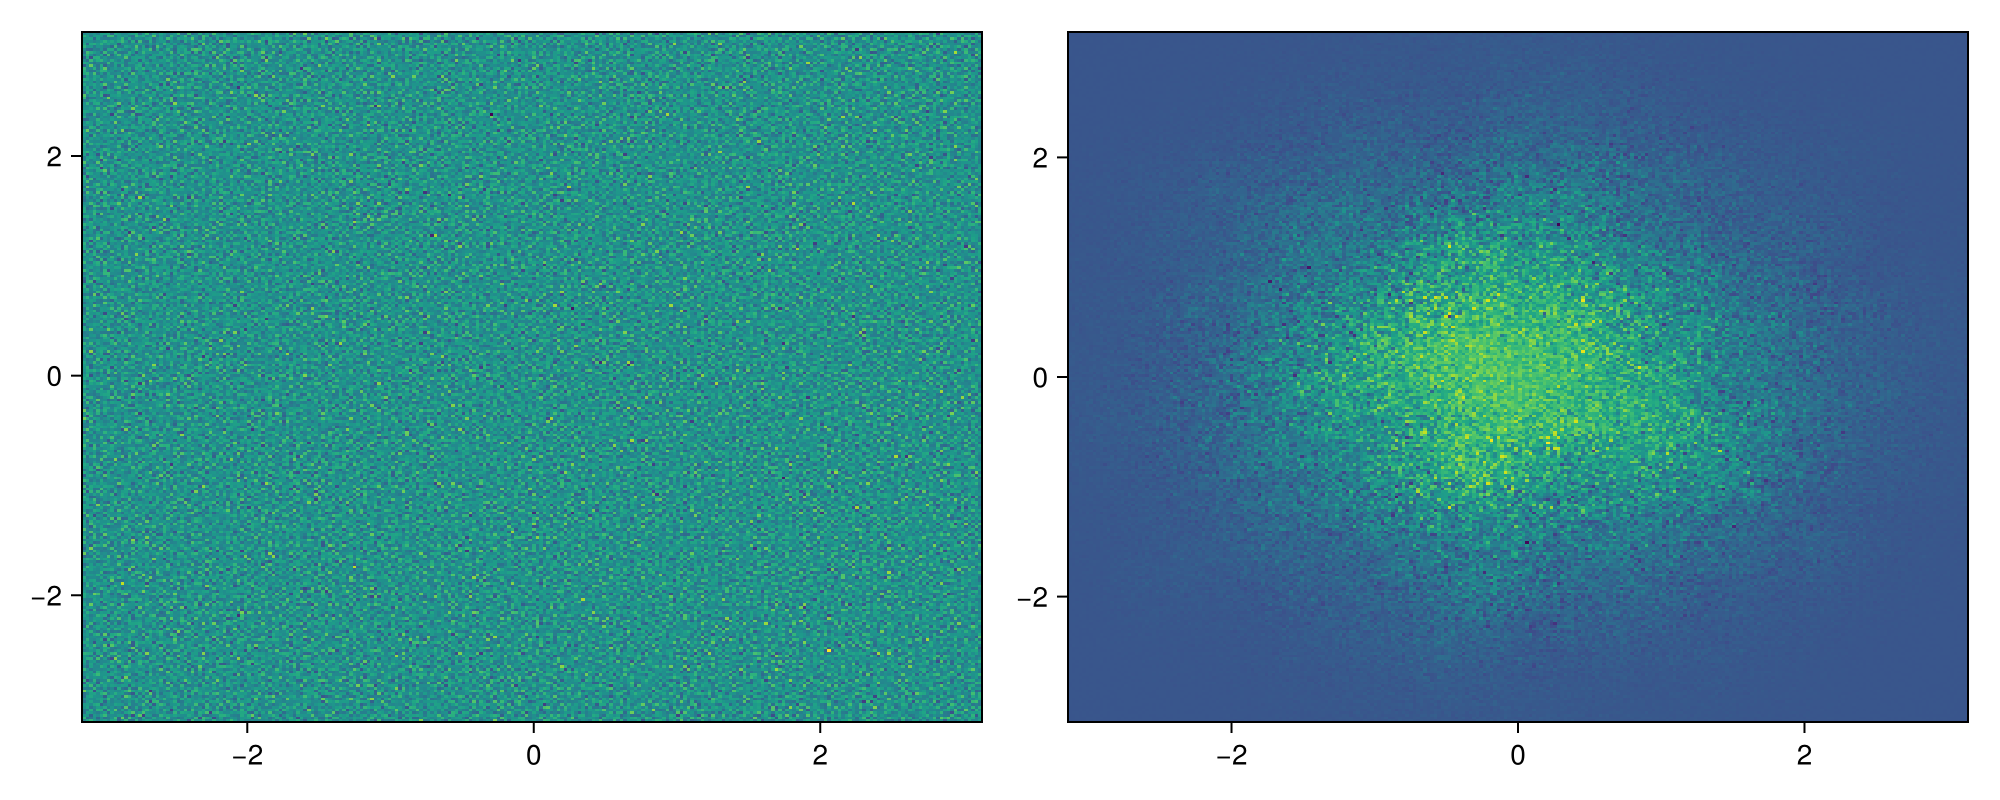

In [46]:
u, v, _ = model.velocities

fig = Figure(size=(1000, 400))
ax  = Axis(fig[1, 1])
heatmap!(ax, ∂x(v) - ∂y(u))
ax  = Axis(fig[1, 2])
heatmap!(ax, model.tracers.c)
display(fig);

In [47]:
using Oceananigans.Operators: Az

function two_dimensional_turbulence(; advection=Centered(), closure=nothing, timestepper=:RungeKutta3)
    # Same steps as before
    model = NonhydrostaticModel(; grid, tracers=:c, advection, closure, timestepper)
    set!(model, u=initial_velocity, v=initial_velocity, c=initial_tracer)
    simulation = Simulation(model, Δt=0.02, stop_time=10)
    conjure_time_step_wizard!(simulation, cfl=0.7)
    
    # Let's compute mean energy, enstrophy, and 
    # tracer variance while time-stepping
    E  = Float64[]
    Ω  = Float64[]
    c² = Float64[]

    function save_diagnostics(sim)
        @info "Collecting diagnostics at time $(sim.model.clock.time)"
        u, v, w = sim.model.velocities
        c = sim.model.tracers.c

        push!(E,  sum((u^2 + v^2) / 2 * Az))
        push!(c², sum(c^2 * Az))
        
        ζ = ∂x(v) - ∂y(v)
        push!(Ω, sum(ζ^2 * Az))
    end

    add_callback!(simulation, save_diagnostics, TimeInterval(1))

    # Now, let's run!
    run!(simulation)

    # Let's plot the results!
    u, v, _ = model.velocities
    fig = Figure(size = (1200, 400))
    ax  = Axis(fig[1, 1])
    heatmap!(ax, ∂x(v) - ∂y(u), colormap = :magma)
    ax  = Axis(fig[1, 2])
    heatmap!(ax, model.tracers.c)
    ax = Axis(fig[1, 3])
    lines!(ax, E  ./ E[1],  label = "Kinetic Energy")
    lines!(ax, Ω  ./ Ω[1],  label = "Enstrophy")
    lines!(ax, c² ./ c²[1], label = "Tracer variance")
    axislegend(ax, position = :rc, framecolor=:transparent, backgroundcolor=:transparent)
    
    return fig
end

two_dimensional_turbulence (generic function with 1 method)

┌ Warning: Inflating model grid halo size to (5, 5, 0) and recreating grid. Note that an ImmersedBoundaryGrid requires an extra halo point in all non-flat directions compared to a non-immersed boundary grid.
└ @ Oceananigans.Models.NonhydrostaticModels ~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/qkc3X/src/Models/NonhydrostaticModels/nonhydrostatic_model.jl:248
[ Info: Initializing simulation...
[ Info: Collecting diagnostics at time 0.0
[ Info:     ... simulation initialization complete (548.262 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (270.242 ms).
[ Info: Collecting diagnostics at time 1.0
[ Info: Collecting diagnostics at time 2.0
[ Info: Collecting diagnostics at time 3.0
[ Info: Collecting diagnostics at time 4.0
[ Info: Collecting diagnostics at time 5.0
[ Info: Collecting diagnostics at time 6.0
[ Info: Collecting diagnostics at time 7.0
[ Info: Collecting diagnostics at time 8.0
[ Info: Collecting diagnost

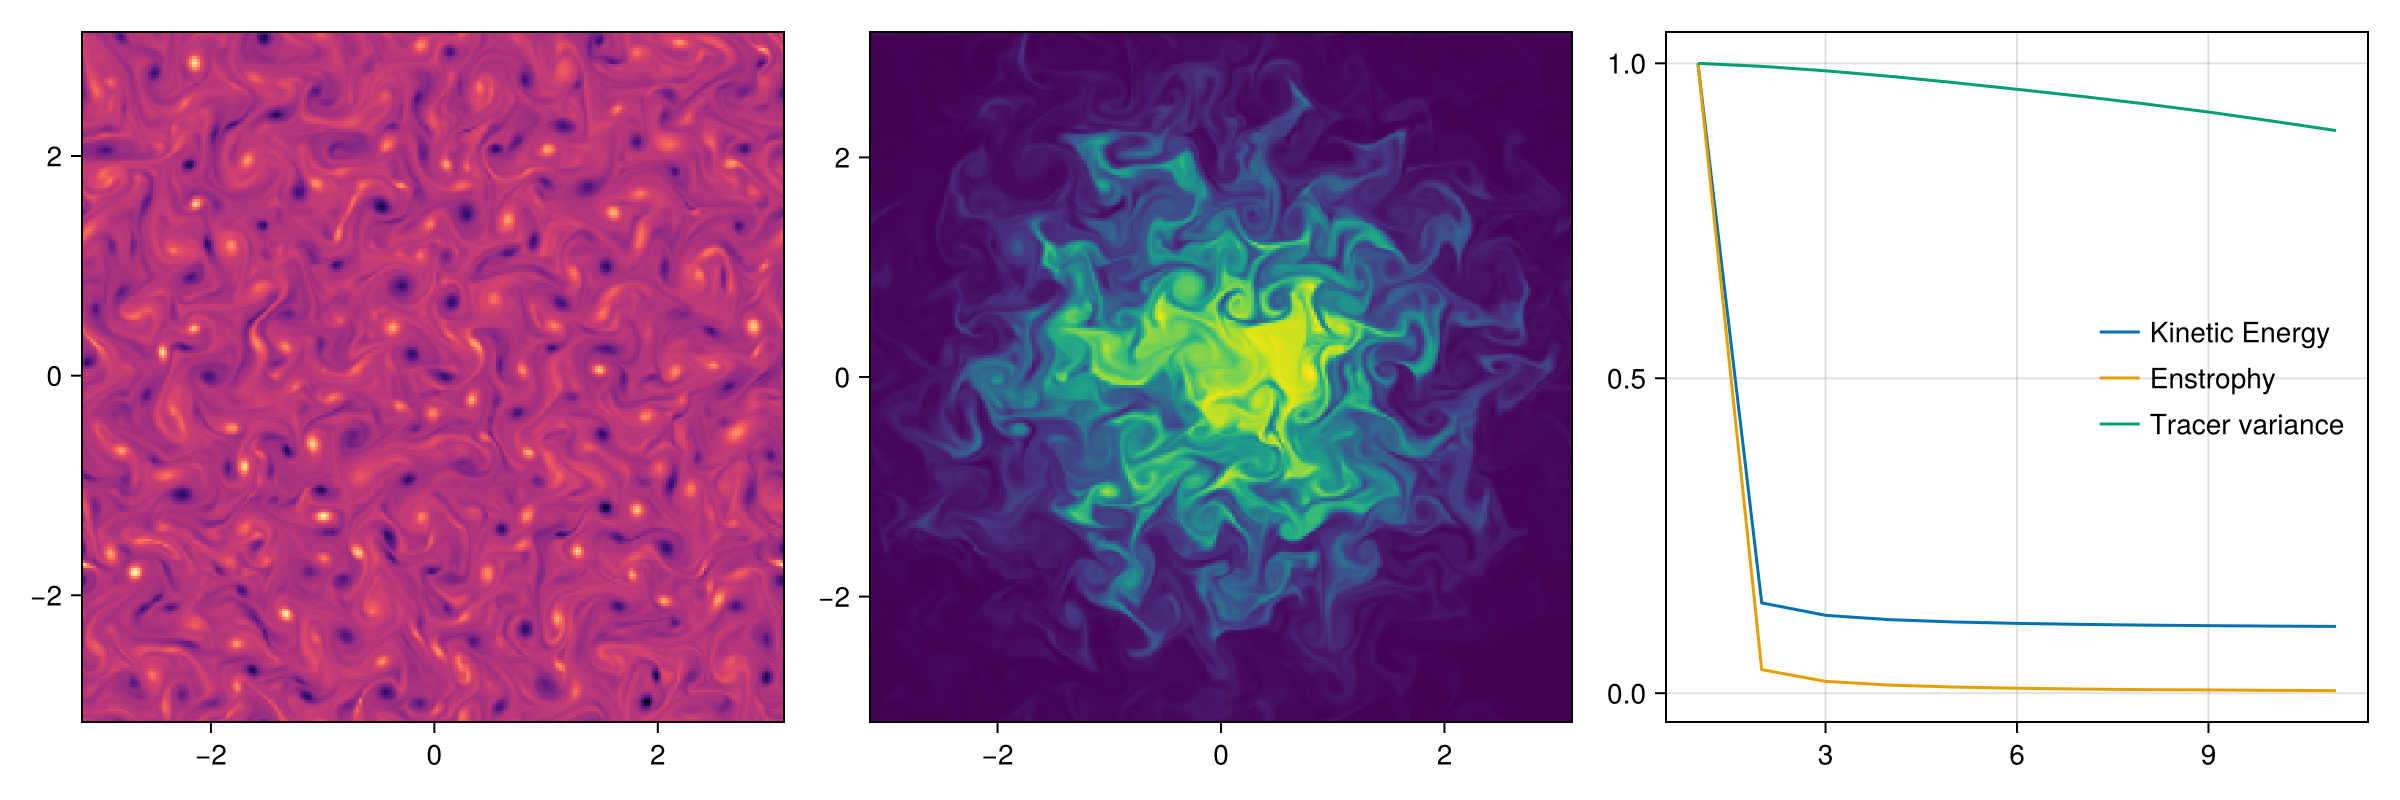

In [48]:
using Oceananigans.TurbulenceClosures: TwoDimensionalLeith, AnisotropicMinimumDissipation, DynamicSmagorinsky, Smagorinsky

fig = two_dimensional_turbulence(advection=WENO(order=9)) 

# What about an Immersed boundary?

In [ ]:
using Oceananigans
using Oceananigans.Models.NonhydrostaticModels: ConjugateGradientPoissonSolver
using Oceananigans.Solvers: DiagonallyDominantPreconditioner
using Oceananigans.Operators: ℑxyᶠᶜᵃ, ℑxyᶜᶠᵃ
using Oceananigans.Solvers: FFTBasedPoissonSolver
using Printf

using Oceananigans.BoundaryConditions: FlatExtrapolationOpenBoundaryCondition

u∞ = 1
r = 1/2
arch = CPU()
stop_time = 200

cylinder(x, y) = (x^2 + y^2) ≤ r^2

Re = 200
Ny = 512
Nx = 216

ϵ = 0 # break up-down symmetry
x = (-6, 12) # 18
y = (-6 + ϵ, 6 + ϵ)  # 12

# TODO: temporarily use an iteration interval thingy with a fixed timestep!!!
kw = (; size=(Nx, Ny), x, y, halo=(6, 6), topology=(Bounded, Bounded, Flat))
grid = RectilinearGrid(arch; kw...)
reduced_precision_grid = RectilinearGrid(arch, Float32; kw...)

grid = ImmersedBoundaryGrid(grid, GridFittedBoundary(cylinder))

advection = Centered(order=2)
closure   = ScalarDiffusivity(ν=1/Re)

no_slip = ValueBoundaryCondition(0)
u_bcs = FieldBoundaryConditions(immersed=no_slip, 
                                east = FlatExtrapolationOpenBoundaryCondition(),
                                west = FlatExtrapolationOpenBoundaryCondition())
v_bcs = FieldBoundaryConditions(immersed=no_slip,
                                east = GradientBoundaryCondition(0),
                                west = ValueBoundaryCondition(0))

boundary_conditions = (u=u_bcs, v=v_bcs)

preconditioner = FFTBasedPoissonSolver(reduced_precision_grid)
reltol = abstol = 1e-7
pressure_solver = ConjugateGradientPoissonSolver(grid, maxiter=10;
                                                 reltol, abstol, preconditioner)

model = NonhydrostaticModel(; grid, pressure_solver, closure,
                              advection, boundary_conditions)

uᵢ(x, y) = 1e-2 * randn()
vᵢ(x, y) = 1e-2 * randn()
set!(model, u=uᵢ, v=vᵢ)

Δx = minimum_xspacing(grid)
Δt = max_Δt = 0.002#0.2 * Δx^2 * Re

simulation = Simulation(model; Δt, stop_time)
u, v, w = model.velocities
wall_time = Ref(time_ns())

function progress(sim)
    vmax = maximum(model.velocities.v)

    msg = @sprintf("Iter: %d, time: %.2f, Δt: %.4f", iteration(sim), time(sim), sim.Δt)

    elapsed = 1e-9 * (time_ns() - wall_time[])

    msg *= @sprintf(", max v: %.2e, wall time: %s", vmax, prettytime(elapsed))

    @info msg
    wall_time[] = time_ns()

    return nothing
end

add_callback!(simulation, progress, IterationInterval(100))

ζ = ∂x(v) - ∂y(u)

p = model.pressures.pNHS

outputs = (; u, v, p, ζ)

simulation.output_writers[:jld2] = JLD2OutputWriter(model, outputs,
                                                    schedule = IterationInterval(Int(2/Δt)),#TimeInterval(0.1),
                                                    filename = prefix * "_fields.jld2",
                                                    overwrite_existing = true,
                                                    with_halos = true)

simulation.output_writers[:drag] = JLD2OutputWriter(model, (; drag_force),
                                                    schedule = IterationInterval(Int(0.1/Δt)),#TimeInterval(0.1),
                                                    filename = prefix * "_drag.jld2",
                                                    overwrite_existing = true,
                                                    with_halos = true,
                                                    indices = (1, 1, 1))

run!(simulation)